# Project Sample

In [16]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
from math import pi

In [17]:
puma = rtb.models.DH.Puma560()

puma.addconfiguration('q1',[0,0,0,0,0,0])
puma.addconfiguration('q2',[0,pi/2,2,pi/2,0,pi/2])

trj1 = rtb.jtraj(puma.q1, puma.q2, 50)

<IPython.core.display.Javascript object>


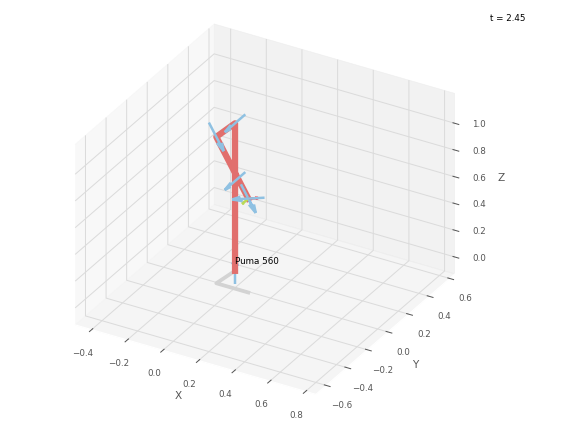

PyPlot3D backend, t = 2.499999999999999, scene:
  Puma 560

In [18]:
puma.plot(trj1.q)

<IPython.core.display.Javascript object>


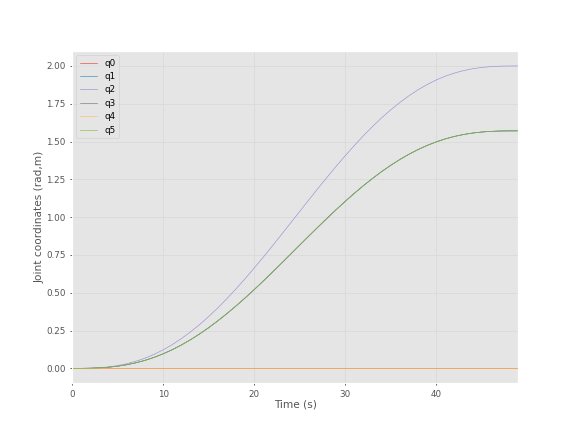

[<AxesSubplot:xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [19]:
rtb.tools.trajectory.qplot(trj1.q, block = True)